In [15]:
import os
from dotenv import load_dotenv
load_dotenv()

import operator
from typing import Annotated
from typing_extensions import TypedDict

# lets play with Tavily

In [9]:
from langchain_community.tools import TavilySearchResults

searchTool = TavilySearchResults(max_results=10)
user_query = "Who is the current Chief Minister of Delhi?"
search_results = searchTool.invoke(user_query)
search_results

[{'title': 'Delhi CM List: Chief Ministers of Delhi Party Names and ...',
  'url': 'https://www.jagranjosh.com/general-knowledge/delhi-chief-ministers-cm-list-party-name-and-tenure-1726561886-1',
  'content': "Rekha Gupta of the Bharatiya Janata Party (BJP) has been declared the new Chief Minister of Delhi. This announcement on February 19, 2025, marks the BJP's return to power in Delhi after 27 years, with the party securing 48 out of 70 assembly seats.\n\nGupta, previously the General Secretary of the Delhi BJP and a former president of the Delhi University Students' Union, won the Shalimar Bagh constituency. Her swearing-in ceremony is scheduled for February 20, 2025, at Ramlila Maidan. [...] Delhi CM List: Chief Ministers of Delhi Party Names and Tenure (1952-2025)\n\nDelhi Chief Ministers:\xa0Rekha Gupta is the 9th Chief Minister of Delhi, representing the Bharatiya Janata Party (BJP). The announcement was made on February 19, 2025, following the BJP's significant victory in the r

In [10]:
# generally these resutls are passed on to LLMs after concatinating the results

formatted_search_docs = "\n\n---\n\n".join(
    [
        f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
        for doc in search_results
    ]
)

print(formatted_search_docs)

<Document href="https://www.jagranjosh.com/general-knowledge/delhi-chief-ministers-cm-list-party-name-and-tenure-1726561886-1">
Rekha Gupta of the Bharatiya Janata Party (BJP) has been declared the new Chief Minister of Delhi. This announcement on February 19, 2025, marks the BJP's return to power in Delhi after 27 years, with the party securing 48 out of 70 assembly seats.

Gupta, previously the General Secretary of the Delhi BJP and a former president of the Delhi University Students' Union, won the Shalimar Bagh constituency. Her swearing-in ceremony is scheduled for February 20, 2025, at Ramlila Maidan. [...] Delhi CM List: Chief Ministers of Delhi Party Names and Tenure (1952-2025)

Delhi Chief Ministers: Rekha Gupta is the 9th Chief Minister of Delhi, representing the Bharatiya Janata Party (BJP). The announcement was made on February 19, 2025, following the BJP's significant victory in the recent assembly elections, where they secured 48 out of 70 seats, marking their return to 

In [11]:
# then these formatted search results can be passed on to the LLM as context and it can be asked to retrieve information from this context. 

prompt_template = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

prompt = prompt_template.format(context=formatted_search_docs, question=user_query)

response = llm.invoke(prompt)
response



AIMessage(content='The current Chief Minister of Delhi is Rekha Gupta, who took office on February 20, 2025.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 2654, 'total_tokens': 2677, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BZx2MJsalDj227kPzdXnCOttDsXlR', 'finish_reason': 'stop', 'logprobs': None}, id='run-e6a70338-dd74-4fcc-b5c8-1f1c50f14846-0', usage_metadata={'input_tokens': 2654, 'output_tokens': 23, 'total_tokens': 2677, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [14]:
response.content

'The current Chief Minister of Delhi is Rekha Gupta, who took office on February 20, 2025.'

In [23]:
# create a node for tavily search

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=5)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [24]:
# invoke it as a function

state = {"question": "Who is the current CM of Delhi?"}
state = search_web(state)

state


{'context': ['<Document href="https://www.bankbazaar.com/voter-id/chief-ministers-of-delhi.html">\nVacant (President’s rule)\n\n2014-2015\n\nNA\n\nNA\n\nArvind Kejriwal\n\n2015- 17 september 2024\n\nAam Aadmi Party\n\nNew Delhi\n\nAtishi Marlena Singh\n\n17 September 2024-Present\n\nAam Aadmi Party\n\nKalkaji\n\nCurrent Chief Minister of Delhi(DL):\n\nChief Minister of DL - Atishi Marlena singh\n\nBorn -\xa0 8th June 1981,\xa0Delhi\n\nPolitical Party -\xa0Aam Aadmi Party\n\nConstituency -\xa0Kalkaji\n\nSpouse -\xa0Pravin Singh\n\nChildren - NA\n\nPolitical Parties in Delhi:\n\nAAP - Aam Aadmi Party\n\nBJP - Bharatiya Janata Party [...] CM name | Duration | Party | Constituency\nBrahm Prakash(Current Chief Minister) | 1952-1955 | Indian National Congress | Nangloi Jat\nGurmukh Nihar Singh | 1955-1956 | Indian National Congress | Daryaganj\nMadan Lal Khurana | 1993-1956 | Bharatiya Janata Party | Moti Nagar\nSahib Singh Verma | 1956-1998 | Bharatiya Janata Party | Shalimar Bagh\nSushma S

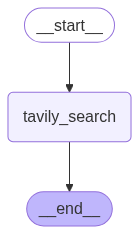

In [26]:
#invoke it as a graph
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("tavily_search", search_web)

# Flow
builder.add_edge(START, "tavily_search")
builder.add_edge("tavily_search", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
state = {"question": "Who is the current CM of Delhi?"}
state = graph.invoke(state)

state

{'question': 'Who is the current CM of Delhi?',
 'context': ['<Document href="https://www.bankbazaar.com/voter-id/chief-ministers-of-delhi.html">\nVacant (President’s rule)\n\n2014-2015\n\nNA\n\nNA\n\nArvind Kejriwal\n\n2015- 17 september 2024\n\nAam Aadmi Party\n\nNew Delhi\n\nAtishi Marlena Singh\n\n17 September 2024-Present\n\nAam Aadmi Party\n\nKalkaji\n\nCurrent Chief Minister of Delhi(DL):\n\nChief Minister of DL - Atishi Marlena singh\n\nBorn -\xa0 8th June 1981,\xa0Delhi\n\nPolitical Party -\xa0Aam Aadmi Party\n\nConstituency -\xa0Kalkaji\n\nSpouse -\xa0Pravin Singh\n\nChildren - NA\n\nPolitical Parties in Delhi:\n\nAAP - Aam Aadmi Party\n\nBJP - Bharatiya Janata Party [...] Arvind Kejriwal | 2013-2014 | Aam Aadmi Party | New Delhi\nVacant (President’s rule) | 2014-2015 | NA | NA\nArvind Kejriwal | 2015- 17 september 2024 | Aam Aadmi Party | New Delhi\nAtishi Marlena Singh | 17 September 2024-Present | Aam Aadmi Party | Kalkaji\nCM name [...] CM name | Duration | Party | Consti

**Observe:** The graph just updates the search result in the state. Lets add a summary node for using an LLM

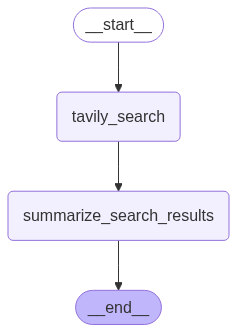

In [28]:

# create a node for tavily search

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=5)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 


def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]
    
    prompt_template = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question} 
    Context: {context} 
    Answer:
    """

    prompt = prompt_template.format(question=question, context=context)    
    
    # Answer
    llm_response = llm.invoke(prompt)
      
    # Append it to state
    return {"answer": llm_response.content}


#build graph
#invoke it as a graph
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("tavily_search", search_web)
builder.add_node("summarize_search_results", generate_answer)


# Flow
builder.add_edge(START, "tavily_search")
builder.add_edge("tavily_search", "summarize_search_results")
builder.add_edge("summarize_search_results",END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
# lets invoke the graph
state = {"question": "Who is the current CM of Delhi?"}
state = graph.invoke(state)

state


{'question': 'Who is the current CM of Delhi?',
 'answer': 'The current Chief Minister of Delhi is Rekha Gupta, representing the Bharatiya Janata Party (BJP), as of February 20, 2025.',
 'context': ['<Document href="https://www.bankbazaar.com/voter-id/chief-ministers-of-delhi.html">\nVacant (President’s rule)\n\n2014-2015\n\nNA\n\nNA\n\nArvind Kejriwal\n\n2015- 17 september 2024\n\nAam Aadmi Party\n\nNew Delhi\n\nAtishi Marlena Singh\n\n17 September 2024-Present\n\nAam Aadmi Party\n\nKalkaji\n\nCurrent Chief Minister of Delhi(DL):\n\nChief Minister of DL - Atishi Marlena singh\n\nBorn -\xa0 8th June 1981,\xa0Delhi\n\nPolitical Party -\xa0Aam Aadmi Party\n\nConstituency -\xa0Kalkaji\n\nSpouse -\xa0Pravin Singh\n\nChildren - NA\n\nPolitical Parties in Delhi:\n\nAAP - Aam Aadmi Party\n\nBJP - Bharatiya Janata Party [...] CM name | Duration | Party | Constituency\nBrahm Prakash(Current Chief Minister) | 1952-1955 | Indian National Congress | Nangloi Jat\nGurmukh Nihar Singh | 1955-1956 | I